In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord

import sys
sys.path.extend(['/Users/lynnej/other_repos/'])

In [2]:
from tvs_software_tools import generate_gp_maps

## Set up sky grid and information ##

In [3]:
nside = 64
# healpix indexes
hpid = np.arange(0, hp.nside2npix(nside))
# Ra/dec in degrees
ra, dec = hp.pix2ang(nside, hpid, lonlat=True)

In [4]:
# Get ecliptic and galactic coordinates
coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
eclip_lat = coord.barycentrictrueecliptic.lat.deg
eclip_lon = coord.barycentrictrueecliptic.lon.deg
gal_lon = coord.galactic.l.deg
gal_lat = coord.galactic.b.deg

In [5]:
# Dustmap from sims_maps  - this is basically just a data directory
# The dustmap data is downloadable from https://lsst.ncsa.illinois.edu/sim-data/rubin_sim_data/maps_may_2021.tgz
# (then just set SIMS_MAPS_DIR to where you downloaded it, after untarring the file)
def get_dustmap(nside=None):
    if nside is None:
        nside = set_default_nside()
    ebvDataDir = os.getenv('SIMS_MAPS_DIR')
    if ebvDataDir is None:
        ebvDataDir = os.path.join(os.getenv('HOME'), 'rubin_sim_data', 'maps')
    filename = 'DustMaps/dust_nside_%i.npz' % nside
    dustmap = np.load(os.path.join(ebvDataDir, filename))['ebvMap']
    return dustmap

In [6]:
# Get the dust extinction values at each healpix
dustmap = get_dustmap(nside)

/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of 

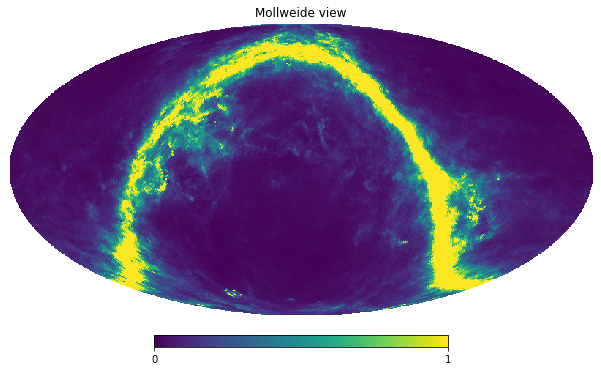

In [7]:
hp.mollview(dustmap, min=0, max=1, norm=None)

## Estimate of survey time requirements ##

In [8]:
# How much survey time .. approximately .. is it likely to take to cover this area? 
# We can use a rough scaling derived from 
# https://github.com/lsst-pst/survey_strategy/blob/master/fbs_1.7/SurveyFootprints-NvisitsVsArea.ipynb

# x = (scale['NvisitPerPoint*']/825) * (scale['Area']/18000) / (scale['t']/0.77)  == constant (~1)

def scalingfunc(survey_frac=None, nvisits_per_pointing=None, area=None):
    defaults = {'survey_frac': 0.77, 'area': 18000, 'nvisits_per_pointing': 825}
    if area is None:
        area = (survey_frac / defaults['survey_frac']) / (nvisits_per_pointing / defaults['nvisits_per_pointing'])
        return area * defaults['area']
    elif nvisits_per_pointing is None:
        nvisits_per_pointing = (survey_frac / defaults['survey_frac']) / (area / defaults['area'])
        return nvisits_per_pointing * defaults['nvisits_per_pointing']
    elif survey_frac is None:
        survey_frac = nvisits_per_pointing / defaults['nvisits_per_pointing'] * area / defaults['area']
        return survey_frac * defaults['survey_frac']

Text(0, 0.5, 'Survey fraction')

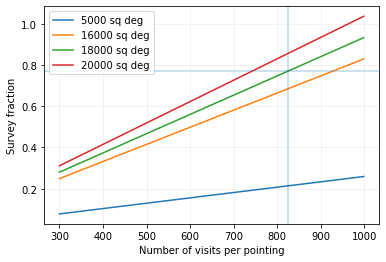

In [9]:
# which leads us to the fraction of a 2x15s 10year survey required 
# from the simulations in the notebook referenced above, I think this is accurate to an order of a % or a few,
# although smaller areas may have more 'edge effects' which would increase their required time 

nvis = np.arange(300, 1000)
for area in (5000, 16000, 18000, 20000):
    plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, area=area), label=f'{area} sq deg')
plt.axhline(0.77, alpha=0.3)
plt.axvline(825, alpha=0.3)
plt.grid(alpha=0.2)
plt.legend(loc='upper left')
plt.xlabel('Number of visits per pointing')
plt.ylabel('Survey fraction')

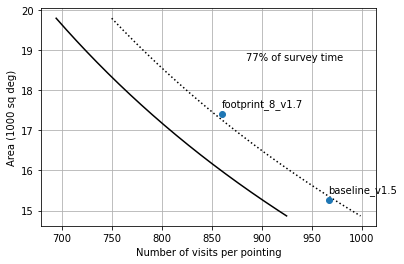

In [10]:
nvis=np.arange(750, 1000)
plt.plot(nvis, scalingfunc(nvisits_per_pointing=nvis, survey_frac=0.77)/1000, 'k:')
plt.plot(nvis/1.08, scalingfunc(nvisits_per_pointing=nvis, survey_frac=0.77)/1000, 'k-')
plt.plot([860, 967], [17413/1000, 15260/1000], linestyle='', marker='o')
plt.annotate('footprint_8_v1.7', xy=[860, 17413/1000+.2])
plt.annotate('baseline_v1.5', xy=[967, 15260/1000+0.2])
plt.figtext(s='77% of survey time', x=0.6, y=0.7)
plt.xlabel('Number of visits per pointing')
plt.ylabel('Area (1000 sq deg)')
plt.grid()
# The solid line = the scaling function / 1.08 .. which both is about the level of variation between 'Minimum'
# number of visits per pointing and "Median" nvisits/pointing (in most simulations) AND a not-unreasonable amount
# of number of visits per pointing to hold as 'contingency'
# .. in other words, plan for the solid line, hope for the dashed line (?)

## Footprint per filter ## 
Due to (potentially) different filter balance being requested by GP science, and overlap between GP priority map footprint and the extragalactic WFD, we need to account for footprint requests per filter. 

Additionally, the GP priority regions contributes very little area toward the SRD requirements (minimum 17500 sq deg covered to min 750 visits per pointing): the bulk of this area must be brought in through extragalactic coverage. 

Specify the GP priority regions first, as they are the most complicated.


In [11]:
survey_footprint = {}
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
for f in filterlist:
    survey_footprint[f] = np.zeros(hp.nside2npix(nside), float)
    
nvis_min_srd = 750

## Low-dust extinction extragalactic

This area is the primary contributor to the SRD requirements (minimum: 17500 sq deg to 750 visits). This pushes the extragalactic footprint toward bigger area; note that this may require rolling cadence implementation over this area, in order to recover SN performance. 

There is some overlap between this area and the GP priority map footprint above, which may require visits in different filters (and those visits may even need to be at different cadences). 
Start out considering them separately and see what we can combine later.

/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of 

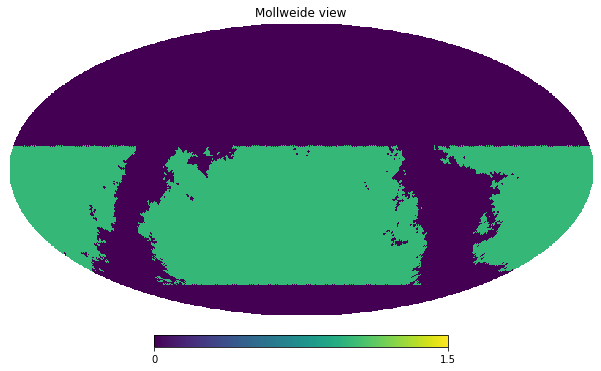

In [12]:
# Define extragalactic WFD between -72 and +12.5 with low dust extinction (dust extinction limit = 0.2)
# These dec and dust limits are used to define the other survey areas as well. 
dust_limit = 0.2
dec_max = 12.0
dec_min = -62.0

exwfd = np.where((dec > dec_min) & (dec < dec_max) & (dustmap < dust_limit), 1, 0)
exgal_filter_balance = {'u': 0.07, 'g': 0.09, 'r': 0.22, 'i': 0.22, 'z': 0.20, 'y': 0.20}

exgal_maps = {}
for f in filterlist:
    exgal_maps[f] = exwfd * exgal_filter_balance[f]

# Where is this on the sky?
hp.mollview(exwfd, max=1.5, norm=None)

In [13]:
# how much area is covered? 
exgal_area = exwfd.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in extragalactic wfd {exgal_area}')

# survey time required?
# ... looking at DESC FOM for footprint_8 vs. baseline_v1.5 -- 
# there seems to be a preference for MORE visits > more area .. so increase nvisits/pointing. 
nvis_exgal = int(825*1.08)
t_exgal = scalingfunc(nvisits_per_pointing=nvis_exgal, area=exgal_area)
print(f"Survey fraction required for extragalactic WFD area {exgal_area: .2f}, at {nvis_exgal} "\
      f"visits per pointing is {t_exgal: .3f}")

Area in extragalactic wfd 17085.50073556372
Survey fraction required for extragalactic WFD area  17085.50, at 891 visits per pointing is  0.789


## Galactic Plane ##

Using the "galactic plane priority map" defined by the TVS/SMWLV groups. 
Note that the galactic plane priority maps don't have an overall scaling, so I'm going to just scale them so that the max visits is about 825 visits total (across all filters) at the places which request the most visits. This is my assumption.

In [14]:
# Note something in the TVS code doesn't seem to work appropriately at nside 128 .. use nside=64. 
gp_maps = generate_gp_maps(nside)

/Users/lynnej/other_repos/tvs_software_tools/generate_galplane_priority_maps.py:50: RuntimeWarning: divide by zero encountered in log10
  hp_log_star_density = np.log10(hp_star_density)


u 0.18500000000000003 0.0
g 1.0075 0.0
r 1.1075000000000002 0.0
i 1.1075000000000002 0.0
z 1.0075 0.0
y 0.23500000000000001 0.0
1.0 0.0


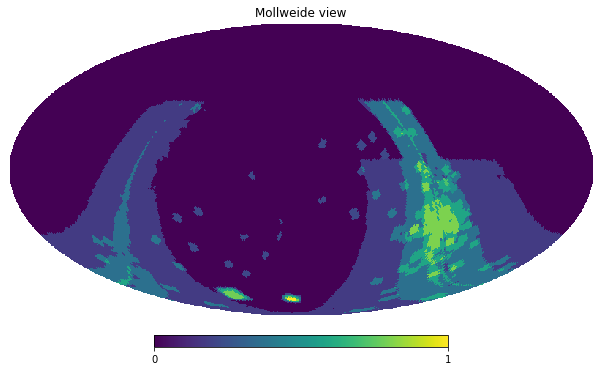

In [15]:
# Figure out how to scale maps per filter
gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    gal_total += gp_maps[f]
    print(f, gp_maps[f].max(), gp_maps[f].min())
# Scale so the peak is 1 (to assign total number of visits across all filters later)
norm = gal_total.max()
gal_total = gal_total / norm

print(gal_total.max(), gal_total.min())
hp.mollview(gal_total, max=1)

In [16]:
# Estimate time required to cover the priority map at 825 visits per pointing, depending on priority cutoff
# This estimate uses the map as a simple mask - on/off coverage.
nvis_gal_peak = 825
for X in np.arange(0, 1.05, 0.1):
    area = len(np.where(gal_total >= X)[0]) * hp.nside2pixarea(nside, degrees=True)
    frac = scalingfunc(nvisits_per_pointing=nvis_gal_peak, area=area)
    print(f'{X:.2f} {area :.2f} {frac: .3f}')

0.00 41252.96  1.765
0.10 13004.86  0.556
0.20 5175.08  0.221
0.30 4895.60  0.209
0.40 1515.76  0.065
0.50 1515.76  0.065
0.60 494.34  0.021
0.70 494.34  0.021
0.80 454.90  0.019
0.90 7.55  0.000
1.00 7.55  0.000


There is not enough time available to observe the entire map to 825 visits per pointing, but we can do a hybrid -- take some fraction of the map and observe that to 825 visits per pointing and then observe the rest at the fraction given in the map. 
(I'm also going to use the fact that I already checked about number of visits per pointing in each filter and the overlap with the extragalactic area means that (assuming the cadence is ok) the visits per filter are satisfied by the extragalactic coverage - so I'll exclude that for this area calculation - see the check below. There's a similar issue with NES coverage away from the bulge, although there it's also filter-dependent).

In [17]:
for X in np.arange(0, 1.05, 0.1):
    gal_total = np.zeros(len(gp_maps['r']), float)
    for f in gp_maps:
        gal_total += gp_maps[f]
    norm = gal_total.max()
    gal_total = gal_total / norm
    gal_total = np.where(exwfd == 1, 0, gal_total)
    gal_total = np.where(gal_total > X, 1, gal_total)
    eff_area = gal_total.sum() * hp.nside2pixarea(nside, degrees=True)
    gp_srd_area = len(np.where(gal_total * nvis_gal_peak >= nvis_min_srd*1.05)[0]) * \
        hp.nside2pixarea(nside, degrees=True)
    frac = scalingfunc(nvisits_per_pointing=825, area=eff_area)
    print(f'{X:.2f} Effective area {eff_area:.2f} (SRD area {gp_srd_area:.2f}) Survey fraction {frac :.3f}')

0.00 Effective area 7876.77 (SRD area 7876.77) Survey fraction 0.337
0.10 Effective area 7876.77 (SRD area 7876.77) Survey fraction 0.337
0.20 Effective area 4846.92 (SRD area 4209.06) Survey fraction 0.207
0.30 Effective area 4798.97 (SRD area 4147.79) Survey fraction 0.205
0.40 Effective area 3051.01 (SRD area 1368.05) Survey fraction 0.131
0.50 Effective area 3037.17 (SRD area 1340.35) Survey fraction 0.130
0.60 Effective area 2679.35 (SRD area 474.20) Survey fraction 0.115
0.70 Effective area 2679.35 (SRD area 474.20) Survey fraction 0.115
0.80 Effective area 2670.29 (SRD area 434.75) Survey fraction 0.114
0.90 Effective area 2586.70 (SRD area 7.55) Survey fraction 0.111
1.00 Effective area 2586.70 (SRD area 7.55) Survey fraction 0.111


So let's use X=0.7 and see what that looks like. (we know we have an oversubscription problem, but this gives us a bit more SRD area for not a lot of time). 

In [18]:
X = 0.7
eclip_dec_min = -20
eclip_ra_max = 180
gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    tmp = np.where(exwfd == 1, 0, gp_maps[f])
    if f not in ['u', 'y']:
        tmp = np.where((dec > eclip_dec_min) & (ra < eclip_ra_max) & (tmp < 0.2*tmp.max()), 0, tmp)
    gal_total += tmp

0.70 Effective area 2479.15 (SRD area 474.20) Survey fraction 0.106


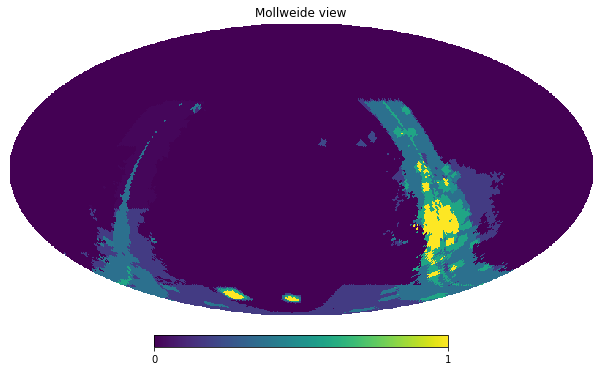

In [19]:
norm = gal_total.max()
gal_total = gal_total / norm
gal_total = np.where(exwfd == 1, 0, gal_total)
gal_total = np.where(gal_total > X, 1, gal_total)
eff_area = gal_total.sum() * hp.nside2pixarea(nside, degrees=True)
gp_srd_area = len(np.where(gal_total * nvis_gal_peak >= nvis_min_srd*1.05)[0]) * \
    hp.nside2pixarea(nside, degrees=True)
t_gal = scalingfunc(nvisits_per_pointing=825, area=eff_area)
print(f'{X:.2f} Effective area {eff_area:.2f} (SRD area {gp_srd_area:.2f}) Survey fraction {t_gal :.3f}')
hp.mollview(gal_total)

In [20]:
# Scale maps per filter to match total
t = 0
new_gp_maps = {}
for f in filterlist:
    # Flatten region above X in the total map
    new_gp_maps[f] = np.where(gal_total == 1, gp_maps[f].max(), gp_maps[f])
    t += new_gp_maps[f].max()
for f in filterlist:
    new_gp_maps[f] = new_gp_maps[f] / t
    print(f'{f} {new_gp_maps[f].max()}')
total = np.zeros(len(new_gp_maps['r']))
for f in filterlist:
    total += new_gp_maps[f]
print(total.max())

u 0.039784946236559135
g 0.21666666666666662
r 0.23817204301075265
i 0.23817204301075265
z 0.21666666666666662
y 0.05053763440860214
0.9999999999999998


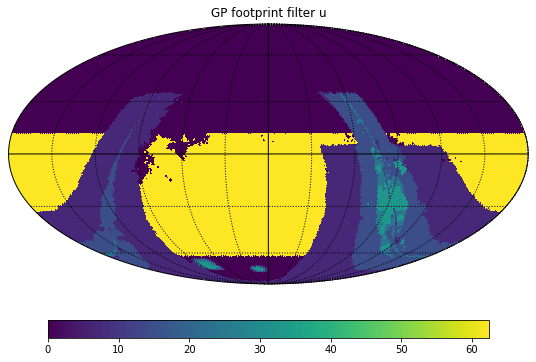

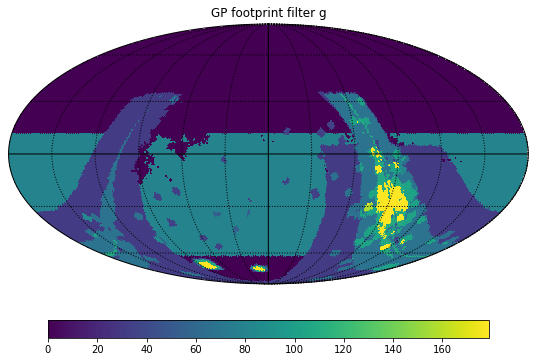

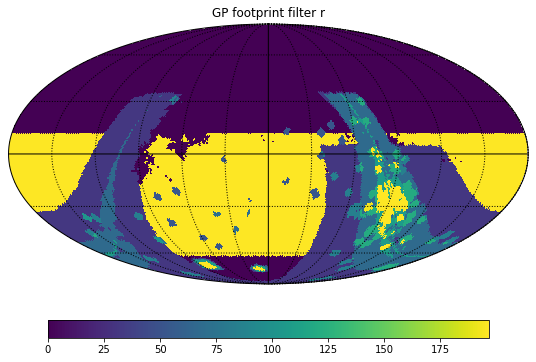

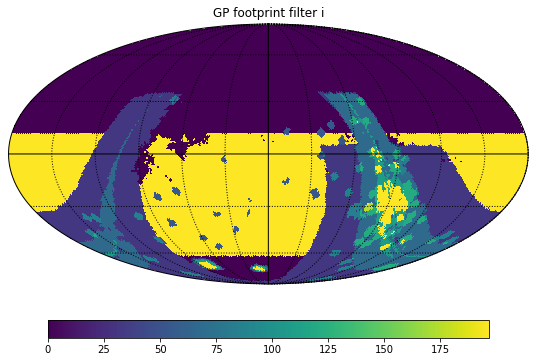

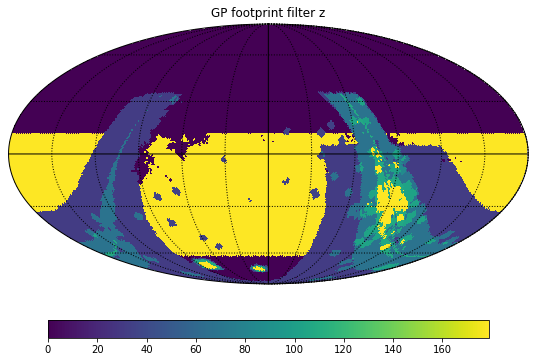

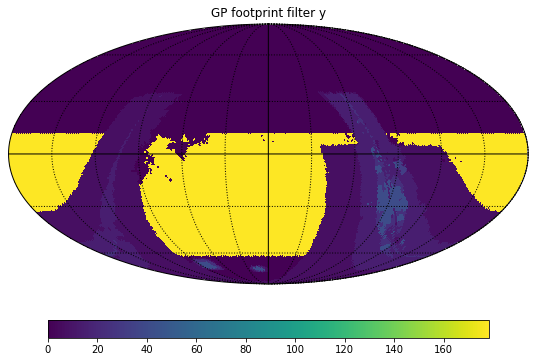

In [21]:
# Check that we can, in fact, remove the wings into the extragalactic footprint - look for more visits in gp wings
# Same with the NES (although this not yet defined .. just check final per-filter plots at end of notebook)
for f in filterlist:
    p = new_gp_maps[f] * nvis_gal_peak + (np.where(new_gp_maps[f] > 0, 0, exgal_maps[f])* nvis_exgal)
    hp.mollview(p, cmap='viridis', cbar=False)
    hp.graticule(dpar=30, dmer=30, verbose=False)
    im = plt.gca().get_images()[0]
    cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                      extendrect=True)
    plt.title(f'GP footprint filter {f}')

Looks good - no areas with *more* visits in the GP wings than in the extragalactic area. So remove those parts of the maps (as was done when calculating the total time above). 

In [22]:
# Remove the Extragalactic and NES overlaps
for f in filterlist:
    new_gp_maps[f] = np.where(exgal_maps[f] > 0, 0, new_gp_maps[f])
    if f not in ['u', 'y']:
        new_gp_maps[f] = np.where((dec > -20) & (ra < 180) & (new_gp_maps[f] < 0.2*new_gp_maps[f].max()), 
                                  0, new_gp_maps[f])

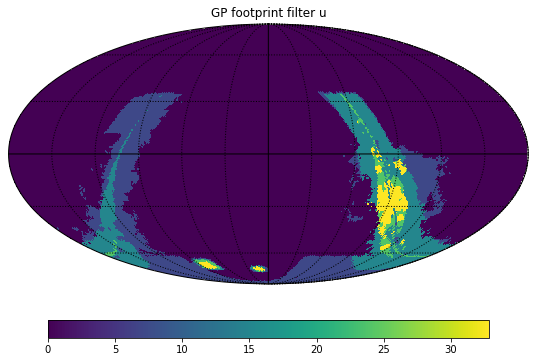

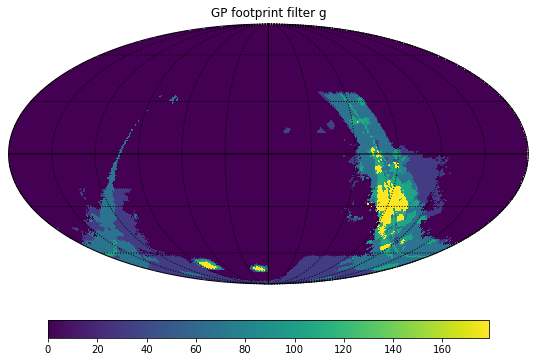

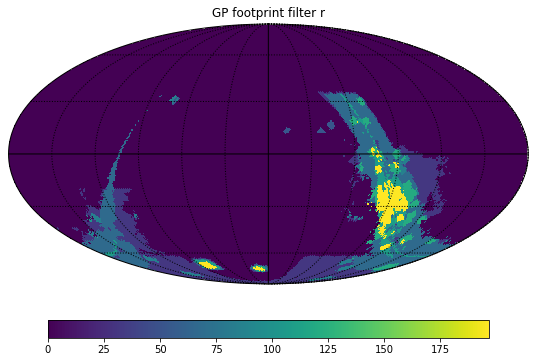

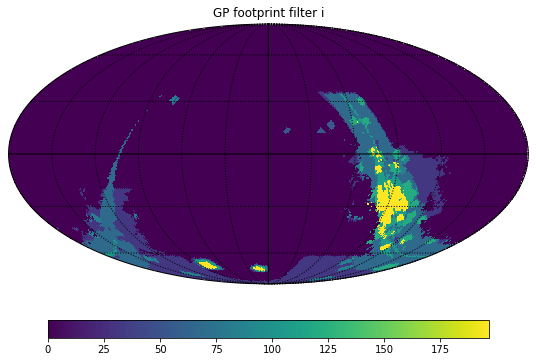

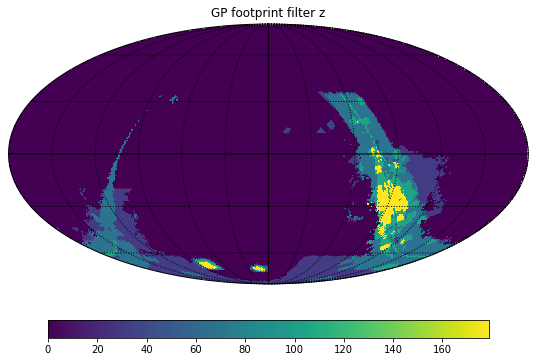

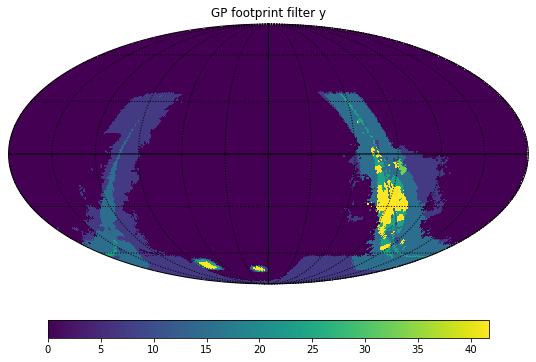

In [23]:
for f in filterlist:
    p = new_gp_maps[f] * nvis_gal_peak
    hp.mollview(p, cmap='viridis', cbar=False)
    hp.graticule(dpar=30, dmer=30, verbose=False)
    im = plt.gca().get_images()[0]
    cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                      extendrect=True)
    plt.title(f'GP footprint filter {f}')

In [24]:
gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    gal_total += new_gp_maps[f]
gp_area = gal_total.sum() * hp.nside2pixarea(nside, degrees=True)
gp_srd_area = len(np.where(gal_total * nvis_gal_peak >= nvis_min_srd*1.05)[0]) * \
    hp.nside2pixarea(nside, degrees=True)
t_gal = scalingfunc(nvisits_per_pointing=825, area=gp_area)
print(f'X threshold {X:.2f} Effective area {eff_area:.2f} (SRD area {gp_srd_area:.2f}) Survey fraction {t_gal :.3f}')
print(f"This should be understood to be MORE approximate than other areas due to complexity of the pointing \n"
      "(likely requiring more visits to cover edges) and failure to account for using 'fractional' visits instead \n "
      "of integers in the calculation.")

X threshold 0.70 Effective area 2479.15 (SRD area 474.20) Survey fraction 0.105
This should be understood to be MORE approximate than other areas due to complexity of the pointing 
(likely requiring more visits to cover edges) and failure to account for using 'fractional' visits instead 
 of integers in the calculation.


## Ecliptic coverage ##

The ecliptic plane has significant overlap with over survey coverage as well. The extragalactic WFD is compatible, so will use that wherever it overlaps. The GP coverage may have different filter / time requirements, but needs more details to check. The ecliptic coverage needs to pick up some pointings around the outside edges of the plane which were not included in the galactic plane priority map -- this is worth checking with the solar system collaboration, as these visits may not be the most useful due to stellar confusion (but are in very interesting areas of the sky for exploration, as these have not generally been covered yet).

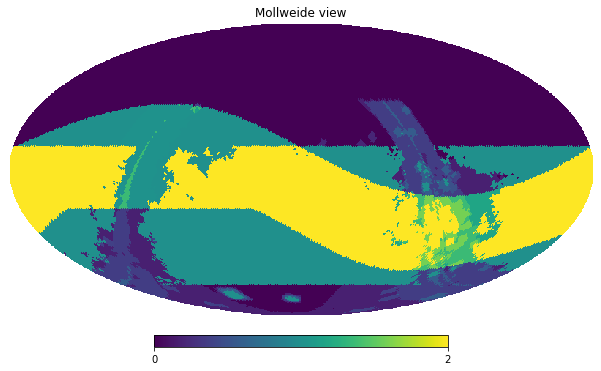

In [25]:
# Ecliptic latitude limits are not symmetric because the northern most point of the ecliptic is +23
eclat_min = -30
eclat_max = 10. 

ecplane = np.where(((eclip_lat > eclat_min) | ((dec > eclip_dec_min) & (ra < eclip_ra_max)))
                   & (eclip_lat < eclat_max), 1, 0)


hp.mollview(ecplane + exwfd + gal_total, max=2, norm=None)

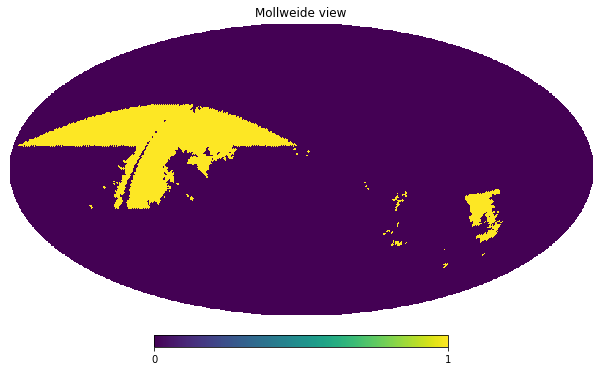

In [26]:
# So let's look at just the northern ecliptic spur part - where it's not potentially coveredby other survey visits
# This includes a small area of high dust extinction further from the plane outside the priority zone .. 
nes = np.where(((eclip_lat > eclat_min) | ((dec > eclip_dec_min) & (ra < eclip_ra_max)))
               & (eclip_lat < eclat_max) 
               & (exwfd == 0) & (new_gp_maps['r'] < 0.07), 1, 0)

nes_filter_balance = {'u': 0, 'g': 0.16, 'r': 0.28, 'i': 0.28, 'z': 0.28, 'y': 0}

nes_maps = {}
for f in filterlist:
    nes_maps[f] = nes * nes_filter_balance[f]

hp.mollview(nes, max=1, norm=None)

In [27]:
# how much area is covered? 
nes_area = nes.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in ecliptic plane total {nes_area}')

nvis_nes=400
t_nes = scalingfunc(nvisits_per_pointing=nvis_nes, area=nes_area)
print(f"Survey fraction required for north ecliptic spur {nes_area: .2f}, at {nvis_nes} visits per pointing {t_nes:.3f}")

Area in ecliptic plane total 3696.2492135099783
Survey fraction required for north ecliptic spur  3696.25, at 400 visits per pointing 0.077


## Southern Celestial Pole ##

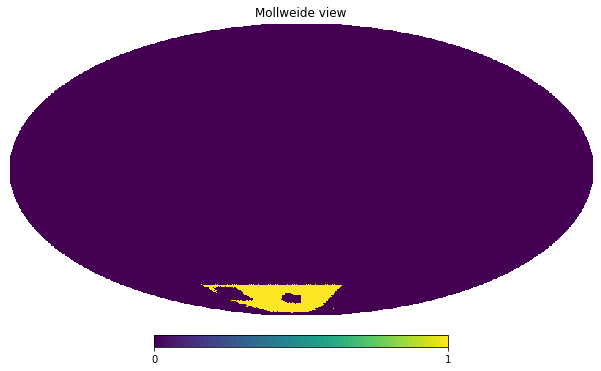

In [28]:
# Add light coverage to the southern celestial pole - the southern part of the sky that is not already covered.
scp = np.zeros(hp.nside2npix(nside), float)
scp = np.where((exwfd == 0) & (gal_total ==0) & (dec < dec_min), 1, 0)

scp_filter_balance = {'u': 1/6, 'g': 1/6, 'r': 1/6, 'i': 1/6, 'z': 1/6, 'y': 1/6}
scp_maps = {}
for f in filterlist:
    scp_maps[f] = scp * scp_filter_balance[f]

hp.mollview(scp)

In [29]:
scp_area = scp.sum() * hp.nside2pixarea(nside, degrees=True)
print(f'Area in southern celestial pole {scp_area}')

nvis_scp = 180 # 6 filters * 3 visits per year * 10 years
t_scp = scalingfunc(nvisits_per_pointing=nvis_scp, area=scp_area)
print(f"Survey fraction required for south celestial pole {scp_area: .2f}, at {nvis_scp} visits per pointing {t_scp: .3f}")

Area in southern celestial pole 683.1850272018897
Survey fraction required for south celestial pole  683.19, at 180 visits per pointing  0.006


## Total ##

In [30]:
# We need at least 5% of the time for DDFs - 1% per pointing
t_ddf = 0.05
ddf_area = t_ddf / .01 * 9.6
# We need a few percent for mini-minisurveys (ToO, twilight NEO? DCR?)
t_mini = 0.03

There is very little survey overlap at this point (some in the NES though)

In [31]:
# Start with a basic survey footprint, just adding all of the above together.
surveyfootprint = (nvis_exgal * exwfd 
                   + nvis_gal_peak * gal_total
                   + nvis_nes * nes 
                   + nvis_scp * scp)
survey_maps = {}
for f in filterlist:
    survey_maps[f] = (nvis_exgal * exgal_maps[f]
                          + nvis_gal_peak * new_gp_maps[f]
                           + nvis_nes * nes_maps[f]
                           + nvis_scp * scp_maps[f])

In [32]:
# We do need to check that we're planning for about 18k sq deg to be visited to at least 825 per SRD
goal_srd = len(np.where(surveyfootprint >= nvis_min_srd)[0]) * hp.nside2pixarea(nside, degrees=True)
res_srd = len(np.where(surveyfootprint >= 825)[0]) * hp.nside2pixarea(nside, degrees=True)
print(f"Area covered to at least {nvis_min_srd} visits per pointing {goal_srd}")
print(f"Area covered to at least {825} visits per pointing {res_srd}")

Area covered to at least 750 visits per pointing 17559.70164510803
Area covered to at least 825 visits per pointing 17085.50073556372


In [33]:
t_total = t_exgal + t_gal + t_nes + t_scp
t_total += t_ddf + t_mini
# effective total area (because we're discounting parts of the GP which are not covered at full depth ..)
area_total = exgal_area + gp_area + nes_area  + scp_area + ddf_area

pd.DataFrame([[exgal_area, t_exgal, nvis_exgal], 
              [gp_area, t_gal, nvis_gal_peak],
              [nes_area, t_nes, nvis_nes], 
              [scp_area, t_scp, nvis_scp], 
              [ddf_area, t_ddf, np.nan], 
              [np.nan, t_mini, np.nan],
              [area_total, t_total, np.nan]], 
             columns=["Area (sq deg)", "Survey Fraction", "Nvis/pointing"], 
             index=["Extragalactic", "GP map", "NES",  "SCP", "DDF", "Mini", "Total"])

,Area (sq deg),Survey Fraction,Nvis/pointing
Extragalactic,17085.500736,0.789350,891.0
GP map,2457.590773,0.105130,825.0
NES,3696.249214,0.076663,400.0
SCP,683.185027,0.006376,180.0
DDF,48.000000,0.050000,NaN
Mini,NaN,0.030000,NaN
Total,23970.525749,1.057520,NaN


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of 

Text(0.5, 1.0, 'Survey footprint (105.8%)')

<Figure size 720x576 with 0 Axes>

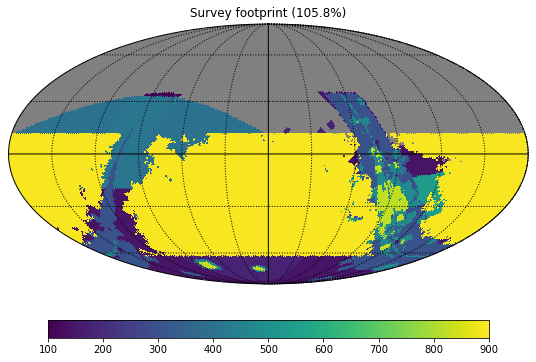

In [34]:
fig = plt.figure(figsize=(10, 8))
f = np.where(surveyfootprint == 0, hp.UNSEEN, surveyfootprint)
#hp.mollview(surveyfootprint, min=0, max=1000, norm=None, cbar=False)
hp.mollview(f, min=100, max=900, norm=None, cmap="viridis", cbar=False)
# Add colorbar / extras
hp.graticule(dpar=30, dmer=30, verbose=False)
im = plt.gca().get_images()[0]
cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                  extendrect=True)
plt.title(f'Survey footprint ({t_total*100:.1f}%)')

<Figure size 720x576 with 0 Axes>

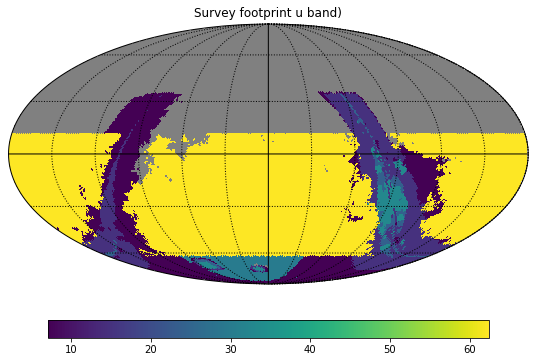

<Figure size 720x576 with 0 Axes>

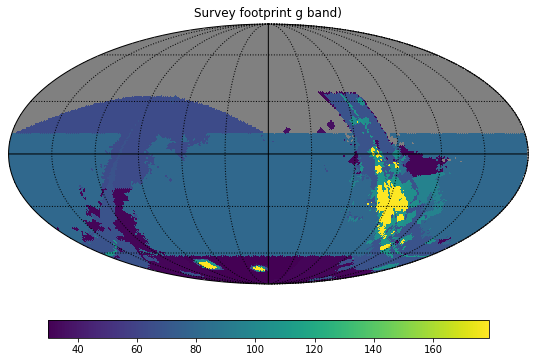

<Figure size 720x576 with 0 Axes>

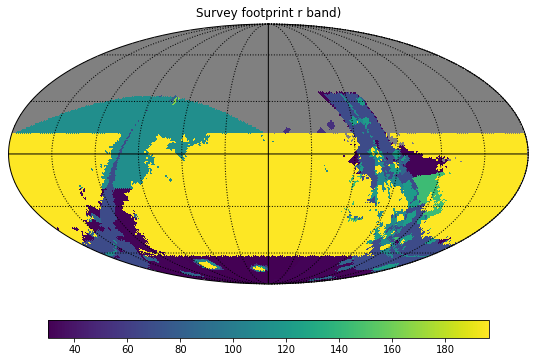

<Figure size 720x576 with 0 Axes>

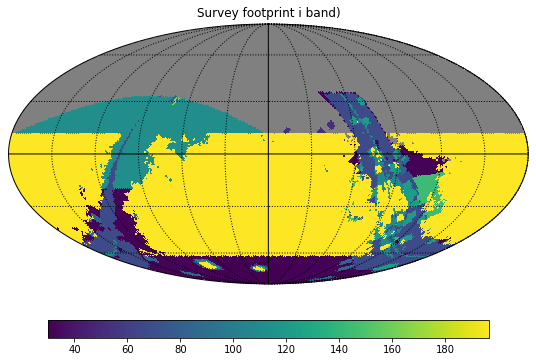

<Figure size 720x576 with 0 Axes>

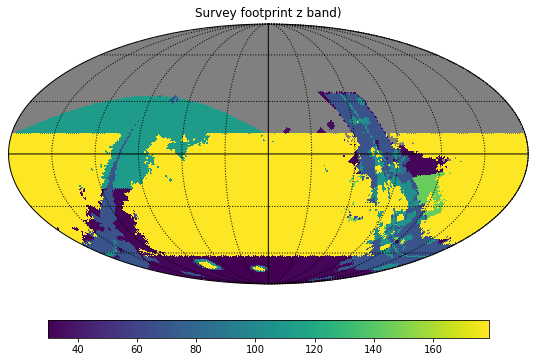

<Figure size 720x576 with 0 Axes>

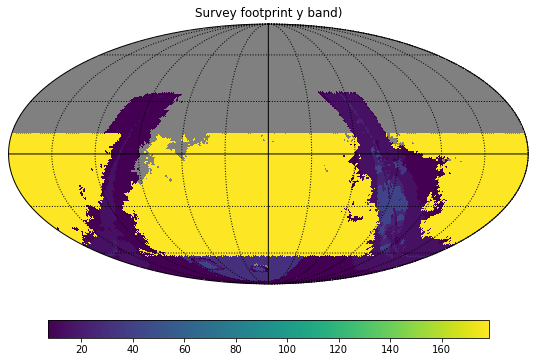

In [35]:
for f in filterlist:
    fig = plt.figure(figsize=(10, 8))
    hp.mollview(np.where(survey_maps[f] < 1, hp.UNSEEN, survey_maps[f]), 
                cmap="viridis", cbar=False)
    # Add colorbar / extras
    hp.graticule(dpar=30, dmer=30, verbose=False)
    im = plt.gca().get_images()[0]
    cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                      extendrect=True)
    plt.title(f'Survey footprint {f} band)')

Some thoughts on this: it's pretty close to what we need . but there are lots of places I could have gotten this wrong or that these approximations don't map well against reality. Some places I could imagine a real simulation needing more time than approximated:

 * I've made an approximation of the effective area and then scaled by the median number of visits - both of these may be neglecting 'tails' in the distribution. Hopefully this is not a large effect, but this treatment could be wrong, and it could be fairly far wrong in the worst case.
 * there are plenty of 'edges' in the footprints -- the edge of the dust extinction limits for the extragalactic footprint and the many, many small areas in the galactic plane priority maps may be problematic. If a field of view doesn't map well onto these edges we will need more visits to cover the edge to the level that is desired. 
 * The footprint has been treated in an 'average' manner, without considering the effects of over or under subscription in various RA zones. This can push the number of visits that are possible in some parts of the sky below what is approximated here. 
 * The distribution of visits has been treated as though cadence doesn't matter; this is almost certainly not true for most of these points in the sky, but is hopefully close enough that it is not a large effect (as long as the cadence for the extragalactic pointings is consistent with what is needed in the wings of the galactic plane, this seems likely to be 'close enough'). 
 
However, most of the questions above seem reasonable to try to address with a simulation and see how bad the assumptions are. We'll give it a go, if it seems useful.

196.02


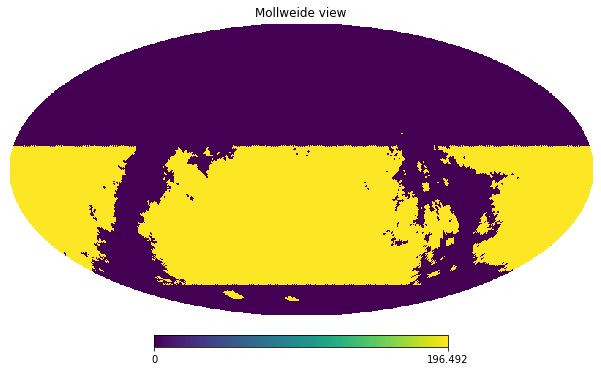

In [36]:
norm = np.median(survey_maps['r'][np.where(survey_maps['r']>0)[0]])
print(norm)
hp.mollview(np.where((survey_maps['r'] > norm-1) & (survey_maps['r'] < norm+1), survey_maps['r'], 0))

In [37]:
np.savez('survey_footprint', 
         u=survey_maps['u']/norm,
         g=survey_maps['g']/norm,
         r=survey_maps['r']/norm,
         i=survey_maps['i']/norm,
         z=survey_maps['z']/norm,
         y=survey_maps['y']/norm)

In [38]:
test = np.load('survey_footprint.npz')
test['r'].max()

1.0024075884290937

196.02


/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/lynnej/anaconda3/envs/rubin/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of 

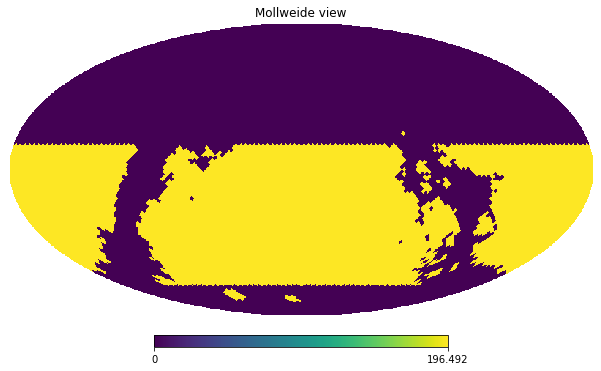

In [39]:
# downgrade the resolution to nside=32
import rubin_sim.utils as rsUtils

low_footprint = {}
new_nside = 32
new_surveyfootprint = rsUtils.healbin(ra, dec, surveyfootprint, nside=new_nside, reduceFunc=np.max, dtype=float)

new_survey_maps = {}
t = 0
for f in filterlist:
    new_survey_maps[f] = rsUtils.healbin(ra, dec, survey_maps[f], nside=new_nside, reduceFunc=np.max, dtype=float)
    
new_norm = np.median(new_survey_maps['r'][np.where(new_survey_maps['r']>0)[0]])
print(new_norm)
hp.mollview(np.where((new_survey_maps['r'] > norm-1) & (new_survey_maps['r'] < norm+1), new_survey_maps['r'], 0))

In [40]:
np.savez('survey_footprint_32', 
         u=new_survey_maps['u']/new_norm,
         g=new_survey_maps['g']/new_norm,
         r=new_survey_maps['r']/new_norm,
         i=new_survey_maps['i']/new_norm,
         z=new_survey_maps['z']/new_norm,
         y=new_survey_maps['y']/new_norm)

<Figure size 720x576 with 0 Axes>

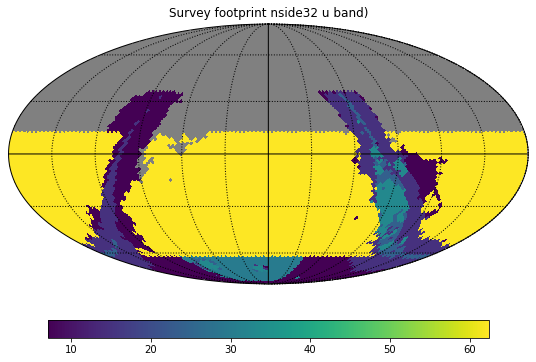

<Figure size 720x576 with 0 Axes>

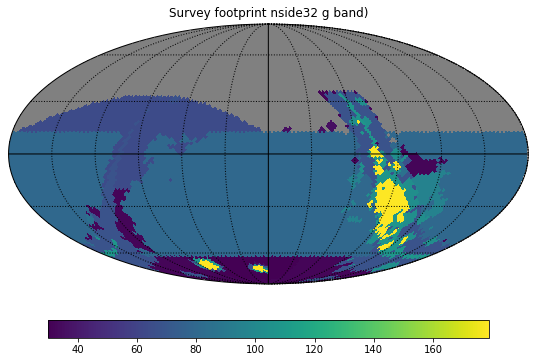

<Figure size 720x576 with 0 Axes>

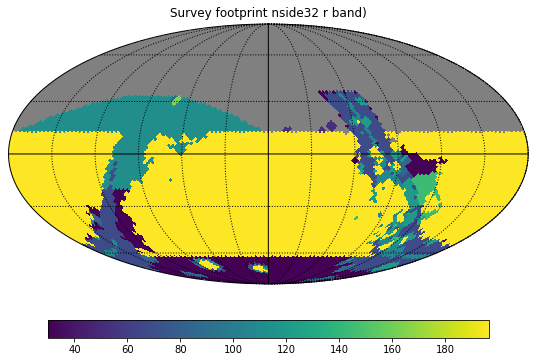

<Figure size 720x576 with 0 Axes>

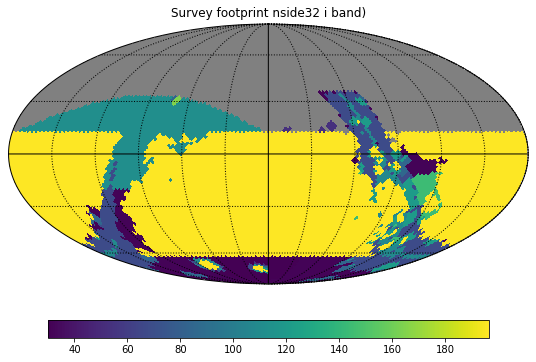

<Figure size 720x576 with 0 Axes>

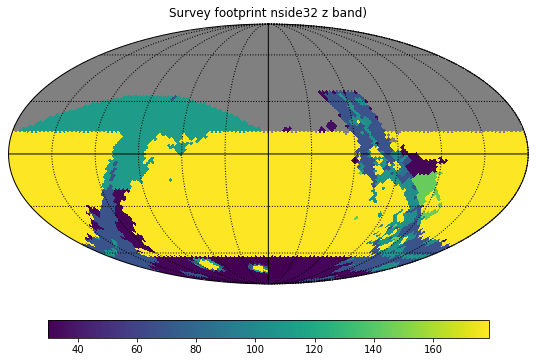

<Figure size 720x576 with 0 Axes>

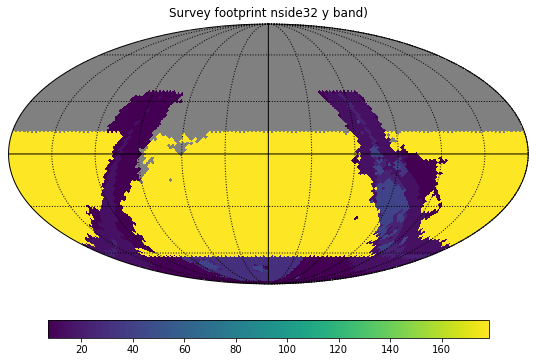

In [41]:
for f in filterlist:
    fig = plt.figure(figsize=(10, 8))
    hp.mollview(np.where(new_survey_maps[f] < 1, hp.UNSEEN, new_survey_maps[f]), 
                cmap="viridis", cbar=False)
    # Add colorbar / extras
    hp.graticule(dpar=30, dmer=30, verbose=False)
    im = plt.gca().get_images()[0]
    cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                      extendrect=True)
    plt.title(f'Survey footprint nside32 {f} band)')